# Linear Regression

Using linear regression, the critical temperatures of superconductors were predicted.  Using the clusters produced by the [clustering](https://github.com/fullmetalchem15t/superconductors/blob/master/Superconductor_clustering.ipynb) notebook, 3 models were created. One only using data from Cluster 1, one only using the data from Cluster 2, and one using all data. Separating the data by cluster before performing linear regression improved results. The models RMSE was 19.50 K without separating and 17.36 K when separated.

In [34]:
import numpy as np
import pandas as pd

#regular expression
import re

#visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.rcParams.update({'font.size': 20})

#machine learn algrothism 
from sklearn.linear_model import ElasticNet,LinearRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import  mean_squared_error,r2_score
from sklearn.pipeline import Pipeline
#from sklearn.model_selection import cross_val_score

#for statistics
from scipy import stats

#for debugging
import pdb

#Do not display warnings
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

#for clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans  
#from hdbscan import HDBSCAN

#dataframes with was initialized in the Superconductor_statistics notebook
from ipynb.fs.defs.Superconductor_statistics import InitializeDataframes
#clustering algorithm Superconductor_clustering notebook
from ipynb.fs.defs.Superconductor_clustering import KMeanTypeI_II


## Initializing data and seperating into clusters.

See [statistics](https://github.com/fullmetalchem15t/superconductors/blob/master/Superconductor_statistics.ipynb) notebook for data wrangling details and [clustering](https://github.com/fullmetalchem15t/superconductors/blob/master/Superconductor_clustering.ipynb) notebook for  clustering details.

In [22]:
#create orignal dataframe
prop_df,atoms_df,material=InitializeDataframes()
prop_df=KMeanTypeI_II(prop_df)

#create bool label I/II database
label1_bool = prop_df['label'] == 1 

#remove label from dataframe. It is not used by linear model
prop_df.drop(['label'],axis=1,inplace=True)

#label 1
prop_label1 = prop_df[label1_bool]
atoms_label1 = atoms_df[label1_bool]
material_label1 = material[label1_bool]

#label 2
prop_label2 = prop_df[~label1_bool]
atoms_label2 = atoms_df[~label1_bool]
material_label2 = material[~label1_bool]

## Property data split into training set and test set
 
Using the properties dataframe, three linear models were created. One from the cluster labeled 1, one from the cluster labeled 2, and the with all labeled data. The data from each model is separated into a training set (to make the model) and a testing set (to test the model), In order to prevent unbalanced data, an equal number of data points from each cluster will be placed into the training set with all labeled data.

In [23]:
#label1
X_label1 = prop_label1.drop(['critical_temp'],axis=1)
y_label1 = prop_label1['critical_temp']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_label1, y_label1, train_size=7000, random_state=42)

#label2
X_label2 = prop_label2.drop(['critical_temp'],axis=1)
y_label2 = prop_label2['critical_temp']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_label2, y_label2, train_size=7000, random_state=42)

#All labels
X_train = pd.concat([X_train1,X_train2])
X_test = pd.concat([X_test1,X_test2])
y_train = pd.concat([y_train1,y_train2])
y_test = pd.concat([y_test1,y_test2])

## Linear Regression Model
 
The linear regression model was produced from a least square method. Three models were created, one using Label 1 only, and one using Label 2 only, and one using all labeled training data. The predicted values found from the two clustered models were combined in order to determine the RMSE when clustering.
 
We had previously tried regulating the linear regression using the scikit-learns elastic net regularization method parameterized with gridSearchCV. The RMSE for this method was larger than a simple least square method so it least square method method was used instead.


Results using ElasticNet : 
<br>RMSE = 19.95 K without clustering 
<br>RMSE = 17.62 K with clustering

Results using least squared method with regularization
<br>RMSE = 19.50 K without clustering 
<br>RMSE = 17.36 K with clustering

In [96]:
def LinearFit(X_train, X_test, y_train, y_test):
    #scaling
    scale = StandardScaler()

    #Linear Regression
    lin_reg = LinearRegression()
    #pineline
    pipeline = Pipeline([('scaler',scale),('linear',lin_reg)])
    pipeline.fit(X_train,y_train)
    r2 = pipeline.score(X_test, y_test)
    print("R squared: {}".format(r2))
    return pipeline
    
    # #ElasticNet (regularized linear model) with grid
    #el_net = ElasticNet(random_state=42)
    ##pineline
    #pipeline = Pipeline([('scaler',scale),('elasticnet',el_net)])
    ##Grid search
    #param_grid = {'elasticnet__l1_ratio': np.arange(0.0,1.1,0.01),           
    #           #    'elasticnet__alpha': [0.000001,0.00001,0.0001,0.001,0.01,0.1,10],
    #              'elasticnet__alpha': np.arange(0.000,0.02,0.001),
    #          #'elasticnet__max_iter':[1,5,10]
    #              #'elasticnet__max_iter':range(1,101,1)
    #              'elasticnet__max_iter':range(100,200,1),
    #              'elasticnet__tol':np.arange(0.0001,0.01,0.0001)
    #             }
    #grid_cv = RandomizedSearchCV(estimator=pipeline,param_distributions=param_grid,cv=4,scoring="r2",
    #                          n_iter=200,random_state=42, verbose=0)  
    #grid_cv.fit(X_train,y_train)
    #r2 = grid_cv.score(X_test, y_test)
    #print("Tuned ElasticNet Alpha: {}".format(grid_cv.best_params_))
    #print("Tuned ElasticNet R squared: {}".format(r2))
    #return grid_cv

In [97]:
def LinearPredict(X_test,y_test,grid_cv):
    y_predict = grid_cv.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_test,y_predict))
    r2 = grid_cv.score(X_test, y_test)
    return y_predict,RMSE,r2
    
def GetGridCoeff(grid_cv):
    return grid_cv.best_estimator_.named_steps['elasticnet'].coef_

def GetPipelineCoeff(pipeline):
    return pipeline.named_steps['linear'].coef_

In [98]:
#Get linear_models
linear_prop=LinearFit(X_train, X_test, y_train, y_test)
linear_prop1=LinearFit(X_train1, X_test1, y_train1, y_test1)
linear_prop2=LinearFit(X_train2, X_test2, y_train2, y_test2)

R squared: 0.6959197953481491
R squared: 0.5285382806896044
R squared: 0.6540118112378012


## Get Predicted Values, RMSE, and r$^2$

The RMSE using all three models is shown below. The prediction of linear regression fitted using all labeled had an RMSE of 19.50 K and an r$^2$ of 0.70. When the labeled data was separated into different gradient boosting model, the RMSE was 17.36 K and the r$^2$ was 0.76. Separating the clustered data therefore was determined to improve accuracy of the linear regression model.  

In [100]:
#get predicted from regression on entire model 
y_pred,RMSE,r2=LinearPredict(X_test,y_test,linear_prop)
y_pred_data1,RMSE_label1,r2_1=LinearPredict(X_test1,y_test1,linear_prop)
y_pred_data2,RMSE_label2,r2_2=LinearPredict(X_test2,y_test2,linear_prop)

#get predicted from regression on seperated labeled data
y_pred_model1,RMSE_model1,r2_model1=LinearPredict(X_test1,y_test1,linear_prop1)
y_pred_model2,RMSE_model2,r2_model2=LinearPredict(X_test2,y_test2,linear_prop2)

#combine the predicted from the two seperated label models 
y_pred_seperated = np.concatenate((y_pred_model1,y_pred_model2))
RMSE_seperated = np.sqrt(mean_squared_error(y_test,y_pred_seperated))
r2_seperated = r2_score(y_test,y_pred_seperated)

#Get coeffients
coef = GetPipelineCoeff(linear_prop)
coef1 = GetPipelineCoeff(linear_prop1)
coef2 = GetPipelineCoeff(linear_prop2)

#coef = GetGridCoeff(linear_prop)
#coef1 = GetGridCoeff(linear_prop1)
#coef2 = GetGridCoeff(linear_prop2)

In [110]:
print('RMSE and from All labeled modeled together')
print('Cluster One: RMSE = {:.2f} K, r^2 = {:.2f}'.format(RMSE_label1,r2_1))
print('Cluster Two: {:.2f} K, r^2 = {:.2f}'.format(RMSE_label2,r2_2))
print('All data:{:.2f} K, r^2 = {:.2f}'.format(RMSE,r2))

print('\nRMSE from labeled clusters are modeled seperately')
print('Cluster One: {:.2f} K, r^2 = {:.2f}'.format(RMSE_model1,r2_model1))
print('Cluster Two: {:.2f} K, r^2 = {:.2f}'.format(RMSE_model2,r2_model2))
print('All Data: {:.2f} K, r^2 = {:.2f}'.format(RMSE_seperated,r2_seperated))

RMSE and from All labeled modeled together
Cluster One: RMSE = 9.58 K, r^2 = -0.21
Cluster Two: 21.79 K, r^2 = 0.58
All data:19.50 K, r^2 = 0.70

RMSE from labeled clusters are modeled seperately
Cluster One: 5.98 K, r^2 = 0.53
Cluster Two: 19.71 K, r^2 = 0.65
All Data: 17.36 K, r^2 = 0.76


## Features with the Largest Coefficients

The features with the largest coefficients are below. It is assumed that the larger the coefficient, the more important that feature is for critical temperature prediction.

In [107]:
#Get Most important coefficients
coeff_df = pd.DataFrame(data = coef,columns=['coeff'],index=X_train.columns)
coeff_df1= pd.DataFrame(data = coef1,columns=['coeff'],index=X_train.columns)
coeff_df2 = pd.DataFrame(data = coef2,columns=['coeff'],index=X_train.columns)

#Important coefficients to entire model
df_all = coeff_df.iloc[coeff_df['coeff'].abs().argsort()[::-1]].round(2).head(10)
df_all.reset_index(level=0, inplace=True)
df_all.rename(columns={'index':'Feature'},inplace=True)
df_all['Cluster'] = 'All Data'
df_all['Rank'] = range(1,11,1)

#Important coefficients to entire model label 1
df1 = coeff_df1.iloc[coeff_df1['coeff'].abs().argsort()[::-1]].round(2).head(10)
df1.reset_index(level=0, inplace=True)
df1.rename(columns={'index':'Feature'},inplace=True)
df1['Cluster'] = 'Cluster 1'
df1['Rank'] = range(1,11,1)

#Important coefficients to entire model label 2
df2 = coeff_df2.iloc[coeff_df2['coeff'].abs().argsort()[::-1]].round(2).head(10)
df2.reset_index(level=0, inplace=True)
df2.rename(columns={'index':'Feature'},inplace=True)
df2['Cluster'] = 'Cluster 2'
df2['Rank'] = range(1,11,1)

#combine into one table
df_merged = pd.concat([df_all,df1,df2])
df_merged = df_merged.pivot(index='Rank',columns='Cluster').swaplevel(i=0, j=1, axis=1)

#reorganizing 
df_multilevel = df_merged.iloc[:,df_merged.columns.get_level_values(0)=='All Data']
df1_multilevel = df_merged.iloc[:,df_merged.columns.get_level_values(0)=='Cluster 1']
df2_multilevel = df_merged.iloc[:,df_merged.columns.get_level_values(0)=='Cluster 2']
pd.concat([df_multilevel,df1_multilevel,df2_multilevel],axis=1)

Cluster                      All Data                        Cluster 1         \
                              Feature   coeff                  Feature  coeff   
Rank                                                                            
1             wtd_gmean_atomic_radius -102.69  wtd_gmean_atomic_radius -35.96   
2              wtd_mean_atomic_radius   93.40   wtd_mean_atomic_radius  35.92   
3                         entropy_fie  -46.86    entropy_atomic_radius  29.10   
4                     entropy_Valence   30.91                 mean_fie  19.42   
5               entropy_atomic_radius   28.24                gmean_fie -17.90   
6                std_ElectronAffinity   28.07             wtd_mean_fie -16.72   
7                 wtd_mean_FusionHeat  -27.28            wtd_gmean_fie  16.37   
8                 wtd_entropy_Valence  -26.57      wtd_mean_FusionHeat -14.11   
9        wtd_mean_ThermalConductivity   25.05          entropy_Valence -13.93   
10               wtd_mean_atomic_mass  -24.61              entropy_fie -12.17   

Cluster              Cluster 2          
                       Feature   coeff  
Rank                                    
1                 wtd_mean_fie -163.11  
2                wtd_gmean_fie  158.50  
3                  entropy_fie -111.55  
4          gmean_atomic_radius  -99.70  
5           mean_atomic_radius   91.50  
6             wtd_mean_Valence   75.95  
7        entropy_atomic_radius   69.66  
8                     mean_fie   69.45  
9                    gmean_fie  -63.35  
10           wtd_gmean_Valence  -61.15

In [108]:
def TempLinearPlot(y_pred1, y_test1,y_pred2, y_test2, axis, plot_title = '',
                   Include_y=True,xlim=[-50,140],ylim=[-50,140]):

    #scatterplot
    #data 2 first so it is on the bottom layer
    p1 = axis.scatter(x=y_test2,y=y_pred2,color='red',alpha=0.2)
    p2 = axis.scatter(x=y_test1,y=y_pred1,color='blue',alpha=0.2)
    plt.legend([p2,p1],['Cluster 1', 'Cluster 2'],fontsize=20)
    #line X_test
    x_plot = np.arange(-50,150,1)
    sns.lineplot(x=x_plot,y=x_plot,color='black',ax=axis)
    plt.title(plot_title,fontsize=24)
    #plt.xlim([-50,140])
    #plt.ylim([-50,140]) 
    plt.xticks([-25,0,25,50,75,100,125])
    plt.yticks([-25,0,25,50,75,100,125])
    if Include_y:
        plt.ylabel('Predicted Critical Temperature (K)',fontsize=20)
        plt.yticks([-25,0,25,50,75,100,125])
    else:
        plt.ylabel('')
        plt.yticks([])
    plt.xlabel('Observed Critical Temperature (K)',fontsize=20)
    plt.xlim(xlim)
    plt.ylim(ylim)   
    

    #show root mean square error
    y_test = np.concatenate((y_test1,y_test2))
    y_pred = np.concatenate((y_pred1,y_pred2))
    RMSE = np.sqrt(mean_squared_error(y_test,y_pred))
    r2 = r2_score(y_test,y_pred)
    text = r'RMSE = ' + format(RMSE,'.2f') + ' K\nr$^2$ = ' + format(r2,'.2f')
    #box_x = x_plot.mean()/2
    #box_y = x_plot.mean()/2
    box_x = 50
    box_y = 75
    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="b", lw=2)
    axis.text(s=text,x=box_x,y=box_y,color='red',bbox=bbox_props,fontsize=20,horizontalalignment='center')

## Linear Regression Predicted vs. Reported Critical Temperature Scatterplots

[]

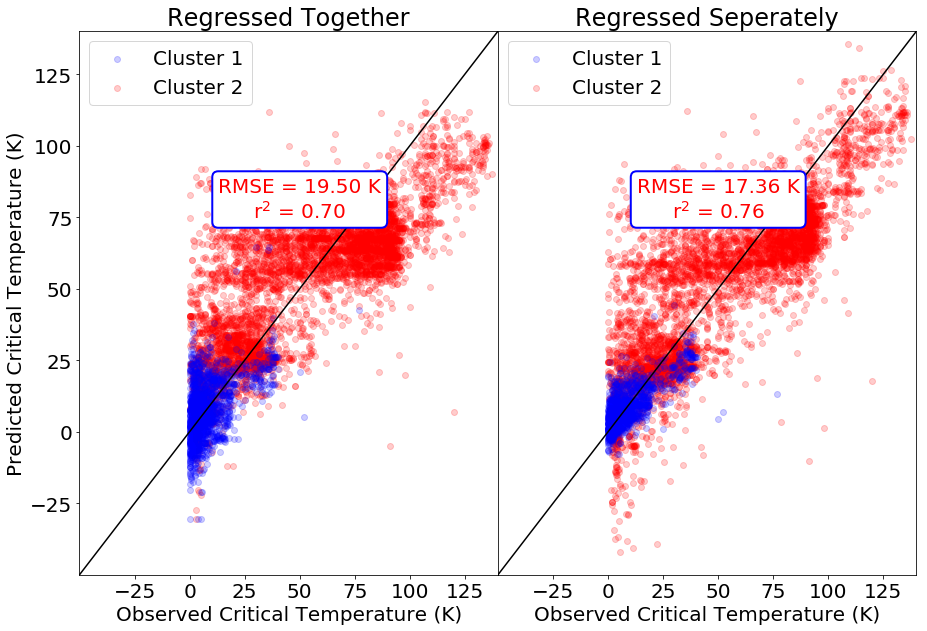

In [109]:
fig = plt.figure(figsize=(15,10)) 
grid = gridspec.GridSpec(1, 2)
grid.update(wspace=0.00, hspace=0.05)
ax1 = plt.subplot(grid[0])
TempLinearPlot(y_pred_data1, y_test1,y_pred_data2,y_test2,ax1,'Regressed Together',True)
plt.subplots_adjust(wspace=None, hspace=None)
ax2 = plt.subplot(grid[1])
#ax2 = fig.add_subplot(1,2,2)
TempLinearPlot(y_pred_model1, y_test1,y_pred_model2,y_test2,ax2,'Regressed Seperately',False)
plt.savefig('images/Linear_plot.jpg',bbox_inches='tight')
plt.plot()